In [2]:
%pip install --upgrade pip > /dev/null
%pip install matplotlib > /dev/null
%pip install PILLOW > /dev/null
%pip install numpy > /dev/null
%pip install pandas > /dev/null
%pip install tensorflow > /dev/null

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

import numpy as np

import os
from copy import copy

zelovoc  = "./"
train    = zelovoc + "dataset/train"
test     = zelovoc + "dataset/test"
validate = zelovoc + "dataset/validate"

def get_image_filepaths( class_="apple" ):
    return [ fn for fn in os.listdir(f'{ train }/{ class_ }') if fn.endswith( ".jpg" ) ]


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Home

# Food Images
#### Martin Krebs,    Filip Brukner,    Hugo Adamove

# Task
Classify fruits and vegtables in image dataset from https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

# Dataset introduction

- data containing 3116 images of fruits and vegtables
- separated into 36 different classes (Apples, Bananas, etc.,)
- already split into test (10%), train (80%), validation (10%) images

# Data Sample

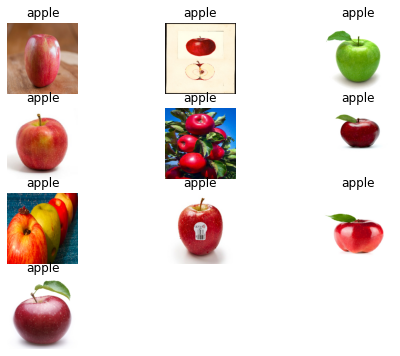

In [3]:
from tensorflow.keras.preprocessing import image

def disp_class( n_samples=10, class_="apple" ):
    images = get_image_filepaths( class_ )
    
    n_samples = min( n_samples, len( images ) )

    select = np.random.choice( images, n_samples, replace=False )
    fig = plt.figure( figsize=( 8, 6 ) )

    for i in range( len( select ) ):
        fp = f'{ train }/{ class_ }/{ select[ i ] }'
        ax = fig.add_subplot( n_samples // 3 + 1 , 3, i+1 )

        fn = image.load_img( fp, target_size=( 256, 256 ) )
        plt.imshow( fn )
        plt.title( class_ )
        plt.axis( 'off' )

    
disp_class( 10, "apple" )


### Observation:
The majority of the apples in the dataset are red, this might cause quite poor performance on real-world data, as apples are quite ofter green or yellow.

# Data Analysis

## Class Distribution

<BarContainer object of 36 artists>

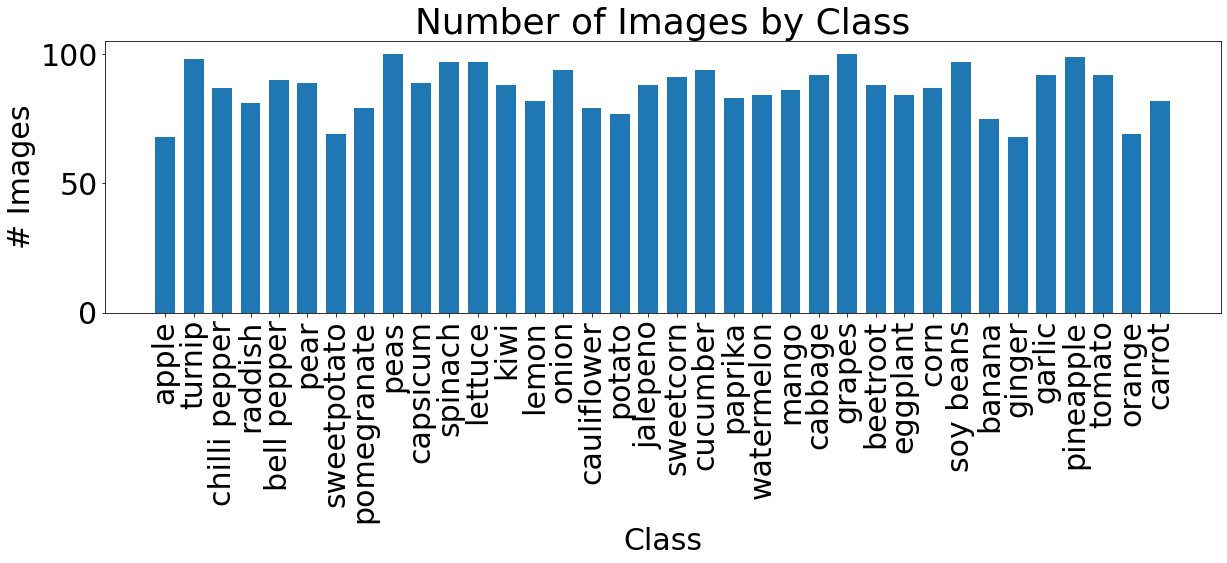

In [4]:
classes = { class_: len( os.listdir( f"{ train }/{ class_ }" ) ) for class_ in os.listdir(train) }

plt.rc('font', size=30)
plt.title("Number of Images by Class")
plt.xlabel('Class')
plt.xticks(rotation='vertical')
plt.ylabel('# Images');

plt.bar(classes.keys(), classes.values(), width = 0.7)

### Observation:
The individual classes are pretty uniformly distributed, which should prevent undesired bias.

In [5]:
def img2np(path, list_of_filename, size = (64, 64)):
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')

        img_ts = image.img_to_array(current_image)

        img_ts = [img_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

def find_img_stat( matrix, class_, title, shape=( 64, 64 ), f=np.mean, **f_kwargs ):
    img = f( matrix, **f_kwargs )
    img = img.reshape( shape )

    plt.imshow( img, vmin=0, vmax=255,  )
    plt.title( title )
    plt.axis( "off" )
    plt.show()
    return img

apple_images = img2np(f'{train}/apple/', get_image_filepaths( "apple" ) )
kiwi_images = img2np(f'{train}/kiwi/', get_image_filepaths( "kiwi" ) )
pineapple_images = img2np(f'{train}/pineapple/', get_image_filepaths( "pineapple" ) )

plt.rc('font', size=10)

## Class Properties - Mean
Calculating `np.mean` on images of Apples


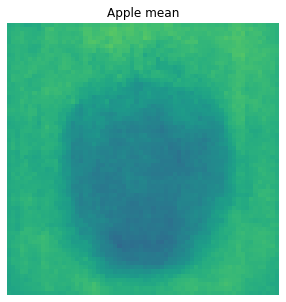

In [6]:
apple_mean = find_img_stat( apple_images, "apple", "Apple mean", f=np.mean, axis=0 )

## Class Properties - Deviation
Calculating `np.std` on images of Pineapples


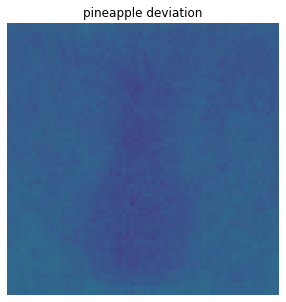

In [7]:
pineapple_dev = find_img_stat( pineapple_images, "pineapple", "pineapple deviation", f=np.std, axis=0 )

## Class Properties - Variance
Calculating `np.var` on images of Kiwi


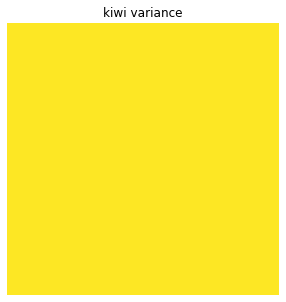

In [8]:
kiwi_var = find_img_stat( kiwi_images, "kiwi", "kiwi variance", f=np.var, axis=0 )

# Class Eigen Images
Using PCA to find componensts, which describe each class the best

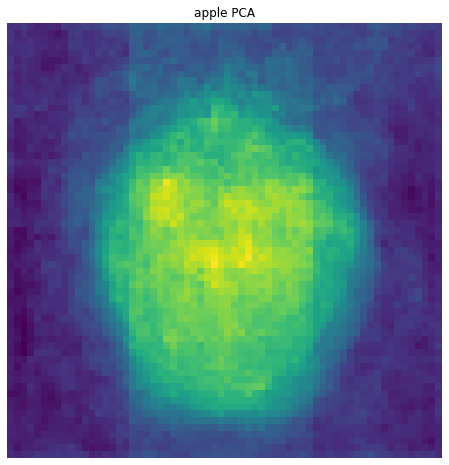

In [9]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages( matrix, n_components = 0.3, size = (64, 64)):
    pca = PCA( n_components=n_components, whiten=True )
    pca.fit( matrix )
    return pca
  
def plot_pca( pca, title, size = (64, 64) ):
    n = pca.n_components_
    fig = plt.figure( figsize=( 8, 8 ) )
    
    r = int( n ** 0.5 )
    c = ceil( n / r)
    
    for i in range(n):
        ax = fig.add_subplot( r, c, i + 1, xticks=[], yticks=[] )
        ax.imshow( pca.components_[ i ].reshape( size ) )
        plt.title( f"{ title } PCA" )
    plt.axis( "off" )
    plt.show()
    
plot_pca( eigenimages( apple_images ), "apple" )



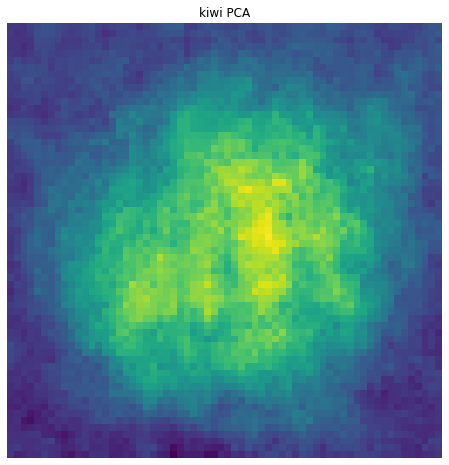

In [10]:
plot_pca( eigenimages( kiwi_images ), "kiwi" )

# Data Preprocessing

In [65]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T



plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open('dataset/train/kiwi/Image_1.jpg')
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, img_titles=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    for img_idx in range(min(len(imgs[0])+1, len(img_titles))):
        axs[0, img_idx].set(title=img_titles[img_idx])
        axs[0, img_idx].title.set_size(16)

    plt.tight_layout()

## Resizing
- The majority of the images in the dataset have different resolution and aspect ratio
- To train our ResNet model, image data is fed in N batches, which requires that all images are of uniform size
- We use `Resize` transform from `torchvision.transforms` to resize all images to uniform `256x256` size

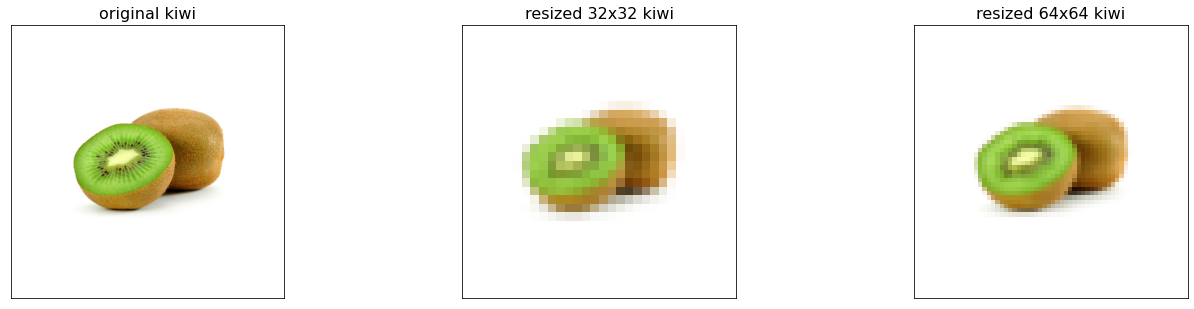

In [91]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in [32, 64]]
plot(resized_imgs, img_titles=['original kiwi', 'resized 32x32 kiwi', 'resized 64x64 kiwi'])

## Rotating
- Rotating images reduces the risk of overfitting on the training data
- We use `RandomRotation` for this purpose


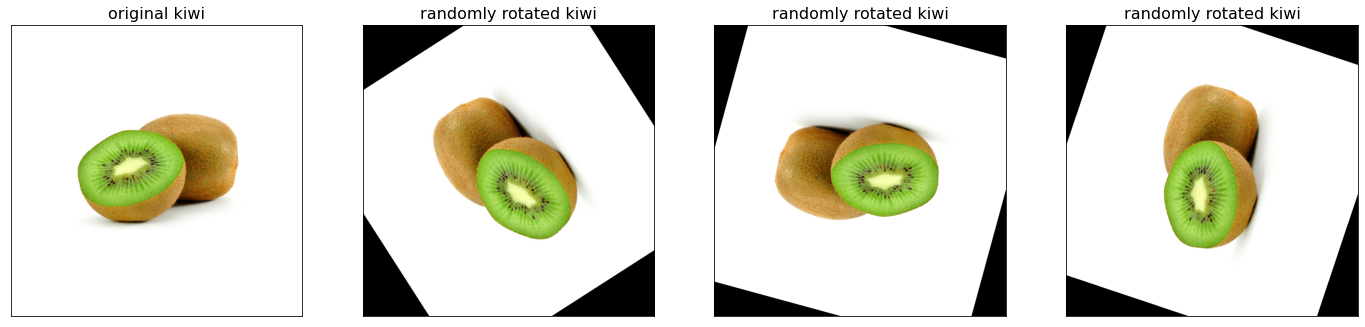

In [92]:
rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(3)]
plot(rotated_imgs, img_titles=['original kiwi'] + ['randomly rotated kiwi']*3)

## Center Cropping
- The most important parts of the images are usually present in the center
- We perform a `CenterCrop` transform to cut off "uninteresting" parts
- This also brings our image size further down to `224x224` which is the required resolution for our model (ResNet)

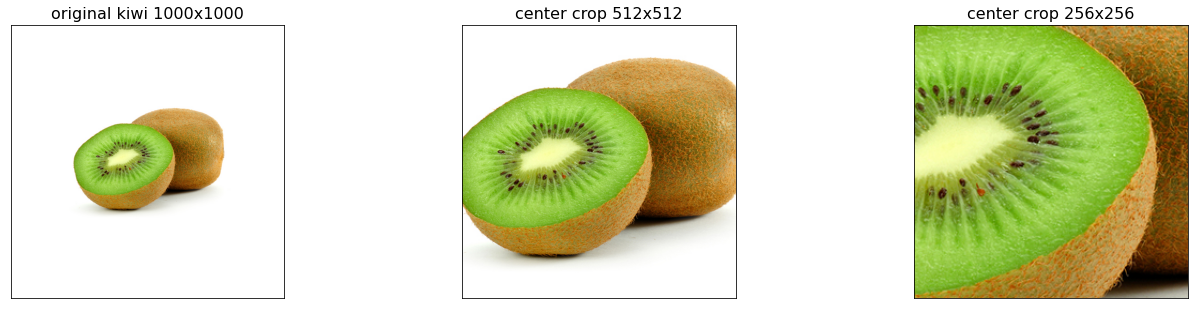

In [93]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (512, 256)]
plot(center_crops, img_titles=['original kiwi 1000x1000', 'center crop 512x512', 'center crop 256x256'])

## Normalizing
- Normalizing an image is performed by subtracting the mean pixel value across all of the training data and dividing by the standard deviation
- This ensures that each pixel has a similar data distribution

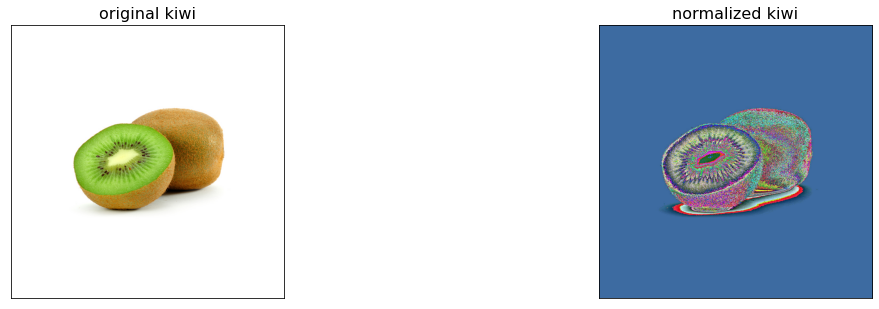

In [94]:
tensor = T.ToTensor()(orig_img)
normalized_tensor = T.Normalize( mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ])(tensor)
img = T.ToPILImage(mode='RGB')(normalized_tensor)
plot([img], img_titles=['original kiwi', 'normalized kiwi'])

## Creating Preprocess Pipeline using `Compose`
```python
transforms = transforms.Compose([
    transforms.Resize( 256 ),
    transforms.CenterCrop( 224 ),
    transforms.ToTensor(),
    transforms.Normalize( mean, std ),
])

train_data = datasets.ImageFolder( train, transform=copy( transforms ) )
test_data = datasets.ImageFolder( test, transform=copy( transforms ) )
```